In [1]:
import sys
import dataloading
import sensors
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy

In [2]:
df = dataloading.load_data2()

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,552,553,554,555,556,557,558,559,560,activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,standing
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,standing
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,standing
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,standing
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,standing


In [4]:
# keep onlhy the acc, gravity, and gyro attributes
train_df = df.iloc[:, [0,1,2,40,41,42,120,121,122,-1]]
train_df.head()

,0,1,2,40,41,42,120,121,122,activity
0,0.288585,-0.020294,-0.132905,0.963396,-0.140840,0.115375,-0.006101,-0.031365,0.107725,standing
1,0.278419,-0.016411,-0.123520,0.966561,-0.141551,0.109379,-0.016112,-0.083894,0.100584,standing
2,0.279653,-0.019467,-0.113462,0.966878,-0.142010,0.101884,-0.031698,-0.102335,0.096127,standing
3,0.279174,-0.026201,-0.123283,0.967615,-0.143976,0.099850,-0.043410,-0.091386,0.085538,standing
4,0.276629,-0.016570,-0.115362,0.968224,-0.148750,0.094486,-0.033960,-0.074708,0.077392,standing


In [5]:
X_train,y_train,X_test,y_test,labels = dataloading.train_test_split(train_df,test_size=0.2)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (8239, 9), y_train: (8239,), X_test: (2060, 9), y_test: (2060,)


In [6]:
print(labels)

['laying' 'sitting' 'standing' 'walking' 'walking_downstairs'
 'walking_upstairs']


In [7]:
### Gruesome test
# we will perform our experiments on acc_mean, gravity_mean, gyro_mean attributes of the dataset
# datasets preprocessing: sliding window 2.56 seconds, 50% overlap
# sampling rate = 50Hz
# filters with median filter and 3rd order low pass butterworh filter (cut-off freq = 20Hz)

# test data
# sampling rate = 20Hz however we do not have resample our dataset with interpolation or
# something else to tackle the disrepancies of sampling rate

In [8]:
def sliding_window_moving_average(data, window_size):
    step_size = window_size // 2  # 50% overlap
    num_windows = (len(data) - window_size) // step_size + 1  # Number of valid windows
    
    return np.array([np.mean(data[i : i + window_size]) for i in range(0, num_windows * step_size, step_size)])

def apply_low_pass_filter(df, fs, cutoff=20, order=3):
    sos = signal.butter(order, cutoff, btype='low', output='sos', fs=fs)
    filtered_data = {col: signal.sosfilt(sos, df[col].values) for col in df.columns}
    return pd.DataFrame(filtered_data)

def process_dataframe(df, fs, window_size):
    filtered_df = df
#     filtered_df = apply_low_pass_filter(df, fs)  # Step 1: LPF
    smoothed_df = pd.DataFrame({col: sliding_window_moving_average(filtered_df[col], window_size) for col in df.columns})  # Step 2: Moving Average
    return smoothed_df

In [9]:
def to_data2_df(acc_df, ag_df, rot_rate_df, orientation_df):
    # first try it without rotational vector
#     dfs = [acc_df[['x', 'y', 'z']],ag_df[['x', 'y', 'z']], rot_rate_df[['x', 'y', 'z']]]
    # it seems that ours AG(x,y,z) is dataset's 1 AG(x,z,-y)
    ag_df_dataset_1 = ag_df.copy()
#     ag_df_dataset_1 = ag_df_dataset_1 / 9.81
    ag_df_dataset_1['x'] = ag_df['x'] / -9.81
    ag_df_dataset_1['y'] = ag_df['y'] / -9.81
    ag_df_dataset_1['z'] = ag_df['z'] / -9.81

    mean_sampling_rate = 12.51
    window_size = int(2.56 * mean_sampling_rate)
    acc_df__preprocessd = process_dataframe(acc_df[['x', 'y', 'z']], mean_sampling_rate, window_size)
    ag_df__preprocessed = process_dataframe(ag_df_dataset_1[['x', 'y', 'z']], mean_sampling_rate, window_size)
    rot_rate_df_preprocessed = process_dataframe(rot_rate_df[['x', 'y', 'z']], mean_sampling_rate, window_size)
    dfs = [acc_df__preprocessd[['x', 'y', 'z']],ag_df__preprocessed[['x', 'y', 'z']], rot_rate_df_preprocessed[['x', 'y', 'z']]]
    

    # Find the minimum number of samples
    min_samples = min(len(df) for df in dfs)

    # Trim each DataFrame to the minimum length
    balanced_df_list = [df.iloc[:min_samples] for df in dfs] 
    balanced_df = pd.concat(balanced_df_list, axis = 1)
    
    return balanced_df 

In [10]:
# what is the actual minimum sampling rate (we want it to compute the len of sliding window)
# sensors.check_sampling_rate(acc_df)
# mean_sampling_rate = 12.51
# window_size = int(2.56 * mean_sampling_rate)
# print(window_size)

In [11]:
# apply low pass filter to the signal
# agc = 2 * np.pi * 1000
# sos = scipy.signal.butter(3, agc, 'lp', output='sos', analog=True)
# sig = acc_df['y']
# filtered = signal.sosfilt(sos, sig)

# sos = signal.butter(3, 20, btype='low', output='sos', fs=fs)

### Test Walking upstairs

In [10]:
data_path = "/Users/admin/Desktop/sensors/data/" + "walking"

acc_df, gravity_df, rot_rate_df, orientation_df = sensors.read_android_logger_sensor_data(data_path)
test_data_df = to_data2_df(sensors.take_df_subset(acc_df, 0.15, 0.15), sensors.take_df_subset(gravity_df, 0.15, 0.15), sensors.take_df_subset(rot_rate_df, 0.15, 0.15), sensors.take_df_subset(orientation_df, 0.15, 0.15))

label_type = 'walking'
label_index = np.where(labels == label_type)[0][0]
real_test_labels = np.full((test_data_df.shape[0]), label_index)
test_df = pd.concat([test_data_df, pd.DataFrame({'activity':real_test_labels})], axis=1).dropna()
test_df.head()

,x,y,z,x,y,z,x,y,z,activity
0,0.110721,-0.473908,0.066715,-0.621254,0.763026,0.040156,-0.027938,-0.151908,-0.272125,3
1,-0.189523,-0.412585,0.641444,-0.633904,0.752074,0.066639,-0.225104,0.099461,-0.081226,3
2,0.093253,-0.117695,0.521862,-0.633374,0.753232,0.067109,0.271755,-0.068809,0.149661,3
3,0.126649,-0.497157,0.377541,-0.637868,0.750047,0.064049,0.423575,-0.402794,-0.062418,3
4,0.115225,-0.555277,1.210039,-0.629851,0.756325,0.099851,0.073836,-0.366255,-0.240279,3


In [13]:
X_train_real, y_train_real, X_test_real, y_test_real,_ = dataloading.train_test_split(test_df,test_size=0.9, scaler_type="standard",should_map_labels=False)
print(f"X_train: {X_train_real.shape}, y_train: {y_train_real.shape}, X_test: {X_test_real.shape}, y_test: {y_test_real.shape}")

client_data = dataloading.to_client(data=(X_train,y_train,X_test_real,y_test_real),max_clients=1)
dataloading.save_client_data(client_data,"dataset_2_real_experiment_14")

X_train: (1, 9), y_train: (1,), X_test: (14, 9), y_test: (14,)


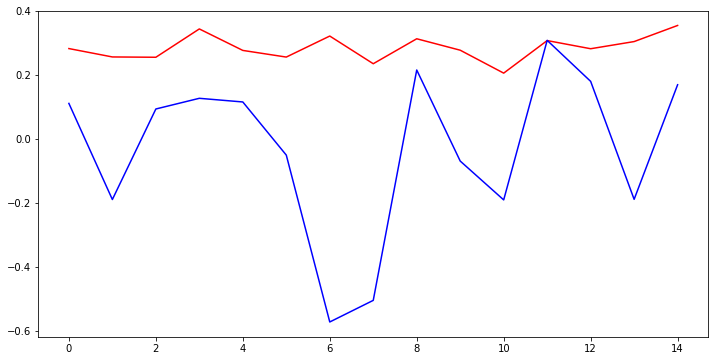

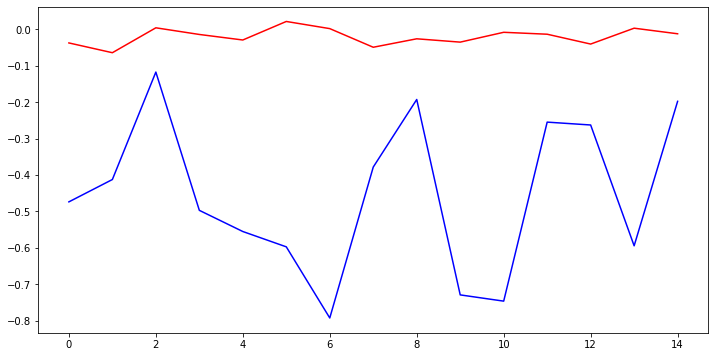

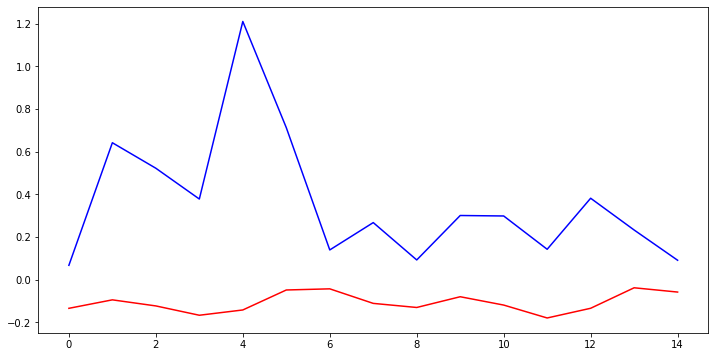

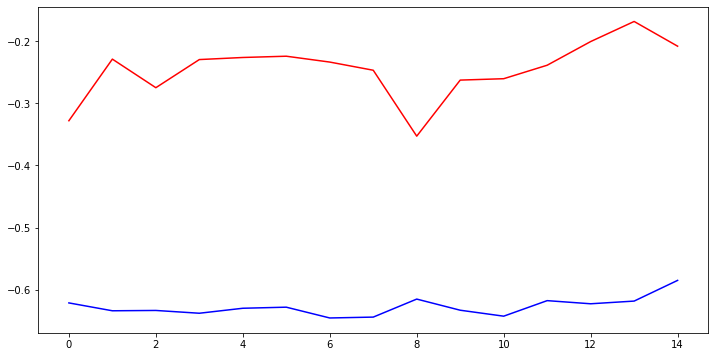

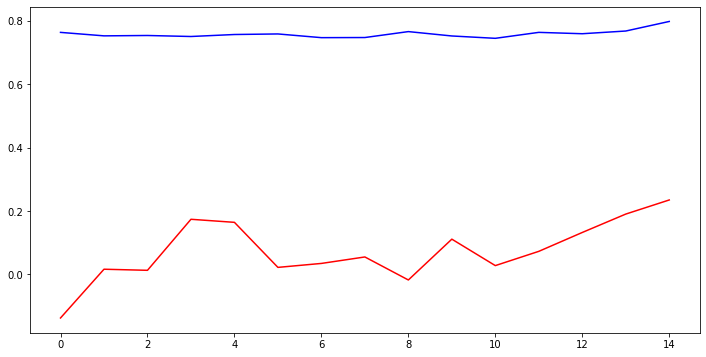

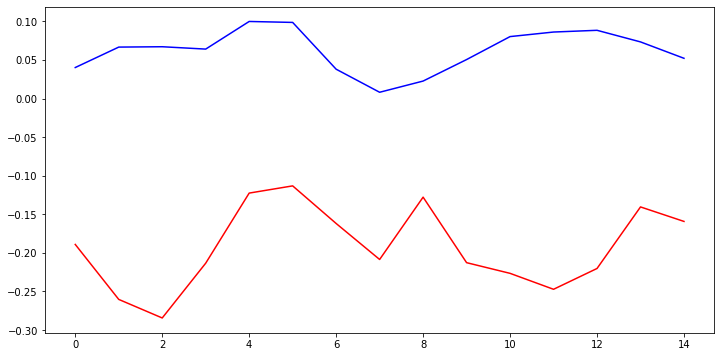

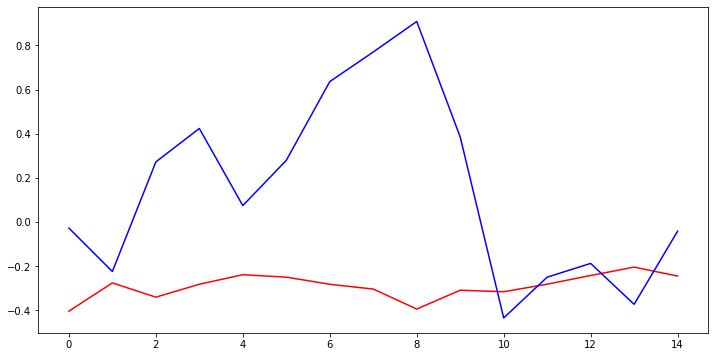

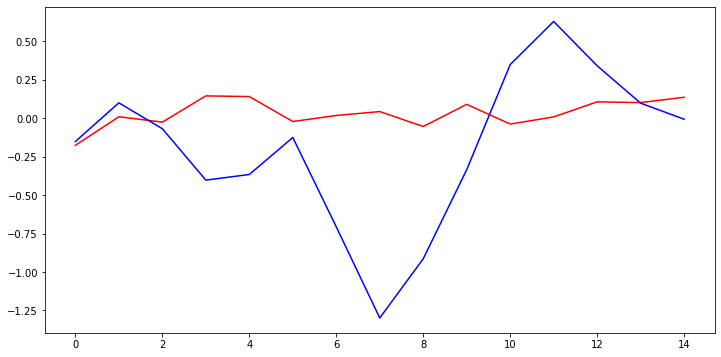

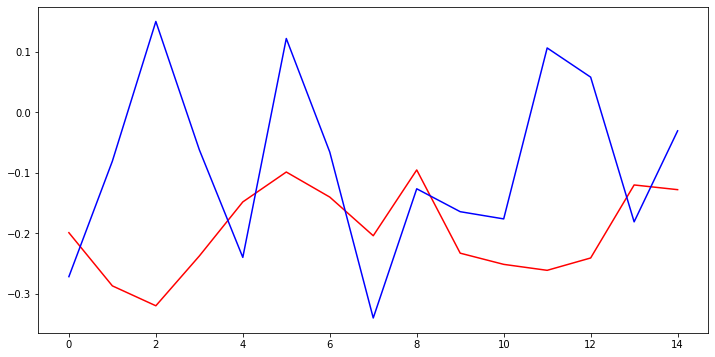

In [14]:
walking_data = df[df['activity'] == 'walking'].to_numpy()
real_data = test_df.to_numpy()

for idx in range(X_train.shape[1]):
    plt.figure(figsize=[12,6])
    plt.plot(walking_data[0:real_data.shape[0], idx], color='r')
    plt.plot(real_data[:, idx], color='b')